# **Train-Test split** (Improve-Evaluate split)
----

## Goals of this notebook:

1. Discuss the proper sample size to calculate average rewards (main metric).
2. Define methods to alternate between train and test mode.
3. Parallelize operations to gain some efficiency.
---
## Library imports

#### 1. RL libraries:

In [1]:
import environments
from agents.agents import TDLambdaPredictor, WatkinsLambda, Sarsa,\
                          QLearning, SarsaLambda, MonteCarloPredictor,\
                          MontecarloController, OffPolicyMontecarlo

#### 2. Data aggregation and matrix operation libraries:

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

#### 3. Plotting libraries:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
import seaborn as sns
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)
plt.style.use('seaborn-pastel')

#### 4. Statistical analysis tools:

In [4]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest, anderson, t, kstest

#### 5. Parallel programming:

In [5]:
import multiprocessing as mp

----

## Common plotting utilities:

#### Average reward time series:

I have modified this function to allow plotting confidence intervals

In [108]:
def plot_reward_time_series(X,Y, far=True, lower=None, upper=None):
    """
    X: a range of numbers starting from the sample size number to the total number of episode + 1
       (to make it inclusive) and incrementing by sample size steps.
    Y: average rewards
    far: bool. If False the plots zooms in.
    lower: the lower bound of average rewards. Same length than Y.
    upper: the upper bound of average rewards. Same length than Y.
    
    returns: the plot container instance
    """
    # domain redefinition to adjust how many x-ticks are displayed dinamically
    max_domain = X[-1]
    multiplier = len(str(max_domain)) - 2
    step = int(str(max_domain)[0]) * 10**multiplier
    domain = np.arange(X[0], max_domain + step, step)
    
    if far:
        ylim = (-1, 1)
        yticks= np.arange(-1,1.05,0.05)
    else:
        max_value = max(0, max(Y))
        ylim = (min(Y)-0.1, max_value)
        yticks = np.round(np.arange(min(Y)-0.1, max_value+0.1, 0.01),2)
    
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlim': (X[0], max_domain),
                  'xticks': domain,
                  'xticklabels': domain,
                  'xlabel': 'Episodes',
                  'ylim': ylim,
                  'yticks': yticks,
                  'yticklabels': yticks,
                  'title': 'Average reward over last {0:,.0f} episodes'.format(X[0])
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    #Axis formatters:
    formatter = ScalarFormatter(useMathText=True)
    #Scientific value display when the total number of episodes is over 1M:
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    # in and out of the money border:
    ax.plot(domain.ravel(), np.zeros_like(domain).ravel(), color='red')
    
    #if bounds of ci are passed as arguments, plot them:
    if lower and upper:
        ax.fill_between(X, lower, upper, alpha=0.1, color='green')
    
    ax.plot(X,Y)
    
    return ax

#### Density plot:

In [7]:
def plot_density(data):
    """
    data: a Panda Series containing every sample of average rewards
    
    returns: both histogram and boxplot container instances
    """
    title = 'Average reward sampling: $\overline{{X}}$={0:.2f}, s={1:.2f}, n={2:,.0f}, num of samples={3:,.0f}'\
            .format(data.mean(),
                    data.std(),
                    data.index.values[0],
                    len(data))
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,10), gridspec_kw={"height_ratios": (.15, .85)}) 
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    sns.boxplot(data=data,x=data, ax=ax_box)
    sns.histplot(data=data, x=data, ax=ax_hist, bins=20, kde=True)
    
    #Delimiting tails:
    ax_hist.axvline(x=np.percentile(data,[2.5]), label='2.5th percentile', c='r')
    ax_hist.axvline(x=np.percentile(data,[97.5]), label='97.5th percentile', c='r')
    ax_hist.legend()
    ax_hist.set_xlabel('Average Reward')
    
    return ax_box, ax_hist

#### Value Function:

In [8]:
def plot_v_func(table, title):
    """
    table: agent's V-table (if agents has a Q-table, it must be transformed before being passed as an argument for this function)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    X = np.linspace(1,10,10)
    Y = np.linspace(12, 20,9)
    Xm, Ym = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (X[0], X[-1]),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in list(X)[1:]] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'ylim': (Y[0], Y[-1]),
                        'yticks': Y,
                        'yticklabels': Y,
                         'ylabel': 'Player\'s Total',
                        'zlim': (-1, 1.5),
                        'zticks': np.arange(-1, 1.8, 0.2),
                        'zticklabels': np.arange(-1, 1.8, 0.2),
                        }
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, projection='3d', title='No usable Ace', **common_style_dict)
    surface_1 = ax.plot_surface(Xm, Ym, table[8:17,:10,0], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, projection='3d', title=' Usable Ace', **common_style_dict)
    surface_2 = ax.plot_surface(Xm, Ym, table[8:17,:10,1], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Colour bar:
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.5])
    fig.colorbar(surface_1,shrink=0.2, aspect=15, cax=cbar_ax)
    
    return ax

#### Policy:

In [9]:
def plot_policy(table, title):
    """
    table: matrix containing action indexes (it must have n-1 dimensions with respect to the agent's Q-table)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    #tick label transformer (used for the colour bar):
    def format_tick(x, pos):
        if x == 0:
            return '{0}-STAND'.format(str(x))
        elif x == 1:
            return '{0}-HIT'.format(str(x))
    
    X = np.arange(-.5,9.5,1)
    Y = np.arange(0.5, 11.5,1)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (-.5, 9.5),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in range(2,11,1)] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'yticks': Y,
                        'yticklabels': np.arange(11,22,1),
                        'ylabel': 'Player\'s Total'
                        }
    #I only plot those states wherein there is risk of going bust after hitting once more and, for the sake of symmetry,
    #I manually modify those non-existing usable-ace-related states:
    table[:8,:,1] = 1
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, title='No usable Ace', **common_style_dict)
    im = ax.imshow(table[7:18,:10,0], cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, title=' Usable Ace', **common_style_dict)
    ax.imshow(table[7:18,:10,1],cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    
    #Colour bar definition
    fig.subplots_adjust(right=0.8)
    original_cmap = plt.get_cmap('bwr')
    
    #Converting a multiple-colour cmap into 2-colour cmap
    cmap = ListedColormap([original_cmap(0), original_cmap(original_cmap.N)])
    bounds = [0, 0.5, 1]
    norm = BoundaryNorm(bounds, original_cmap.N)    
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.85])
    
    fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                 shrink=0.2,
                 aspect=15,
                 cax=cbar_ax,
                 boundaries= [0] + bounds + [2],  
                 extend='both',
                 ticks=[0,1],
                 format = FuncFormatter(format_tick),
                 spacing='proportional',
                 orientation='vertical',
                 alpha= 0.5)
    
    return ax

----

## Experiment Definition:

#### Montecarlo method:

In [10]:
def run_experiment(environment, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

In [11]:
def run_experiment_one_step(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

In [12]:
def run_experiment_sarsa(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        next_action = None
        while not terminal:
            if next_action:
                action = next_action
            else:
                action = agent.follow_policy(state)
                
            next_state, reward, terminal, _ = env.step(action)
            if not terminal:
                next_action = agent.follow_policy(next_state)
            else:
                next_action = None
                
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state, next_action)   
            
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

#### Wrapper:

So far, I have deployed a total of 7 agents and 3 different experiments. I must admit that this can be somewhat confusing and needs to be untangled. Let's wrap  it all up in an informing dictionary:

In [13]:
agents_methods = {'MonteCarloPredictor': run_experiment,
                  'MontecarloController': run_experiment,
                  'OffPolicyMontecarlo': run_experiment,
                  'TDLambdaPredictor': run_experiment_one_step,
                  'WatkinsLambda': run_experiment_sarsa,
                  'Sarsa': run_experiment_sarsa,
                  'QLearning': run_experiment_one_step,
                  'SarsaLambda': run_experiment_sarsa}

In [14]:
agents_methods['MonteCarloPredictor']

<function __main__.run_experiment(environment, agent, episodes, show, save=None, collect_rewards=None, train=True)>

----

## On Sample Size & Bootstrapping (to evaluate policies):

So far, I have just used an arbitrary number to decide how often rewards should be averaged. However, it would be nice to find a good balance between finding a good estimation of the real value of a policy and execution time.

It seems obvious that the larger the sample size, the lower the standard deviation. So, I will empirically assess how standard deviation behaves when enlarging the sample size and then decide the sample size I will use for future experimentation.

On the other hand, since average rewards distribution is unknown, I will attempt to generate some sort of bootstrapping to generate an empirical distribution and in turn provide CI for average rewards estimation (instead of a single number).

The expectation at this point is to achieve a Gaussian-like distribution, as stated by the Law of Large Numbers and the Central Limit theory.


In [15]:
#create an environment instance:
env = environments.make('hitstand')

In [16]:
#Create an agent that uses an arbitrary policy to play (policy is not important for the problem at hand)
class Deterministic(MonteCarloPredictor):
    #V-table is initialized full of 0s
    def follow_policy(self, observation, *args):
        #if your cards add up to a number greater than 17, stand; otherwise, hit:
        if observation[0] > 17:
            return 0
        else:
            return 1
    

I set the ground for a parallel execution by defining two functions: the first one enqueues RL experiments and the second ones dequeues them:

In [17]:
def put_q(q, episodes, show_every, save_every, collect_every):
    """
    q: Queue from multiprocessing library
    """
    sampler = Deterministic(env)
    q.put(agents_methods[sampler.get_parent_class_str()](env, sampler, episodes, show_every, save_every, collect_every, train=False))
    
def get_q(q):
    """
    q: Queue from multiprocessing library
    
    """
    return q.get()

In [18]:
def wrap_sample_size_choice(sample_sizes, num_of_samples=10, number_of_runs=10):
    """
    sample_sizes: a list of integers.
    num_of_samples: an integer to indicate how many times rewards are averaged at
                    each run. It helps simulate a bootstrapping process.
    number_of_runs: number of times an experiment is repeated for each sample size.
    
    returns: a dictionary containing the reported stds and means for each run and sample size
             dict[sample_size] = {stds: [std_run_1, std_run_2 ....],
                                  means: [mean_run_1, mean_run_2 ....]
                                  }
    """
    summary = {}    
    for sample_size in sample_sizes:
        summary[sample_size] = {'stds': [],
                                'means': [],
                                }
        # I use a server (Manager()) to allow the Queue to interact with different processes
        queue = mp.Manager().Queue()
        
        EPISODES =  sample_size * num_of_samples
        SHOW_EVERY = 1_000_000
        SAVE_EVERY =  None
        COLLECT_EVERY = sample_size
        
        # I enqueue every run
        for _ in range(0, number_of_runs):
            mp.Process(target=put_q, args=(queue, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY,)).start()

        getter = []  
        #I create a pool of workers to handle dequeuing and subsequent execution:
        pool = mp.Pool(8)
        for _ in range(0, number_of_runs):
            getter.append(pool.apply_async(get_q, (queue,)))

        #I extract results from every process and attach them to the dictionary:
        for r in getter:
            np_results = np.array(r.get())
            summary[sample_size]['stds'].append(np_results.std())
            summary[sample_size]['means'].append(np_results.mean())
        
    
    return summary            

`This execution might take several minutes`
1. I define some sample sizes.
2. For each of them, I run 15 experiments.
3. Ten average rewards are generated at each run.

In [19]:
sample_size_options=[100, 250, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
sample_size_summary = wrap_sample_size_choice(sample_size_options, number_of_runs=15)

Process Process-56:
Process Process-60:
Process Process-54:
Process Process-57:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-59:
Process Process-50:
Process Process-58:
  File "/home/xavi/Documents/Blackjack/env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/xavi/Documents/Blackjack/env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/xavi/Documents/Blackjack/env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-51:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/xavi/Documents/Blackjack/env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xavi/Documents/Blackjack/env/lib/python3.9/multiprocessin

KeyboardInterrupt: 

I display the results in a boxplot fashion; The number of runs is small, so it is better to use a non-parametric method:

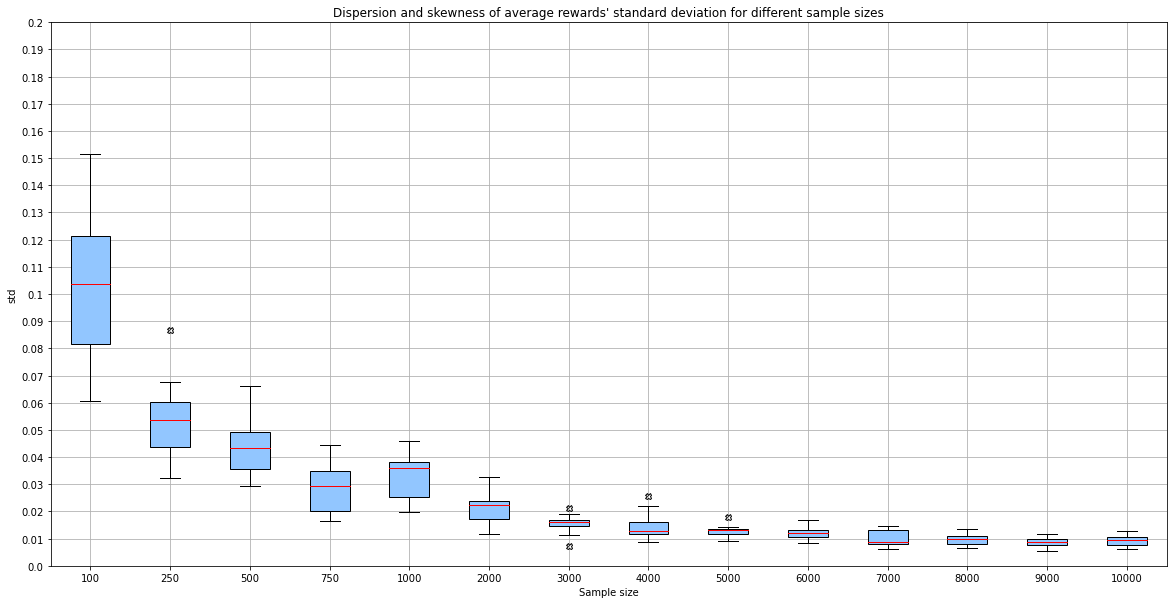

In [117]:
def box_plotting(summary):
    stds = []
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlabel': 'Sample size',
                  'ylabel' : 'std',
                  'ylim': (0,0.2),
                  'yticks': np.linspace(0, .2, 21),
                  'yticklabels': np.linspace(0, .2, 21),
                  'title': 'Dispersion and skewness of average rewards\' standard '
                           + 'deviation for different sample sizes'
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    #unpacking stds:
    for sample_size in summary:
        stds.append(summary[sample_size]['stds'])
        
    ax.boxplot(stds, labels=summary.keys(),
               positions=[i for i in range(0,len(summary))],
               patch_artist=True,
               medianprops={'color': 'red'},
               sym= 'X')  
    ax.grid()
    
    return ax

box_plotting(sample_size_summary);

Given the above results, I will use a 8,000-reward sample size to average: median is near 0.01 std and upper whisker is around 0.015 std.

Let's simulate bootstrapping in order to check whether or not we get a T-Student distribution (unknown population's std) for the average reward metric:

`This execution might take long`

In [143]:
def bootstrap_simulation(sample_size, num_of_samples=1_000, number_of_runs=10):
    """
    sample_sizes: sample size.
    num_of_samples: number of samples for bootstrapping.
    number_of_runs: number of times bootstrapping is repeated
    
    returns: a dictionary containing average rewards for each run.
             
    """
    summary = {}    

    
    for run in range(1,number_of_runs + 1):
        
        summary[run] = []
        # I use a server (Manager()) to allow the Queue to interact with different processes
        queue = mp.Manager().Queue()
    
        cores = mp.cpu_count()
    
        EPISODES =  sample_size * num_of_samples // cores
        SHOW_EVERY = 1_000_000
        SAVE_EVERY =  None
        COLLECT_EVERY = sample_size
        
        # I enqueue every run
        for _ in range(0, cores):
            mp.Process(target=put_q, args=(queue, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY,)).start()

        getter = []  
        #I create a pool of workers to handle dequeuing and subsequent execution:
        pool = mp.Pool(cores)
        for _ in range(0, cores):
            getter.append(pool.apply_async(get_q, (queue,)))

        #I extract results from every process and attach them to the dictionary:
        run_results = []
        for r in getter:
            run_results.extend(r.get())
        
        summary[run] = run_results
    
    return summary

In [121]:
SAMPLE_SIZE = 8_000
bootstrap = bootstrap_simulation(SAMPLE_SIZE)

Episode 1000000:
Jack:
	-Cards: ['6C', '4S']
	-Value : 10
Dealer:
	-Cards: ['AS']
	-Value : 11
Jack decides to: HIT
	-Cards: ['6C', '4S', '9S']
	-Value : 19
Jack decides to: STAND
	-Cards: ['6C', '4S', '9S']
	-Value : 19Episode 1000000:

Dealer:Jack:
	-Cards: ['5H', '6C']

	-Value : 11	-Cards: ['AS', '5D', '5S']
	-Value : 21
THE HOUSE BEATS JACK

Dealer:
	-Cards: ['9D']
	-Value : 9
Jack decides to: HIT
	-Cards: ['5H', '6C', '2D']
	-Value : 13
Jack decides to: HIT
	-Cards: ['5H', '6C', '2D', '9S']
	-Value : 22
Dealer:
	-Cards: ['9D']
	-Value : 9
THE HOUSE BEATS JACK
Episode 1000000:
Jack:
	-Cards: ['10H', '3C']
	-Value : 13
Dealer:
	-Cards: ['8D']
	-Value : 8
Jack decides to: HIT
	-Cards: ['10H', '3C', '10D']
	-Value : 23
Dealer:
	-Cards: ['8D']
	-Value : 8
THE HOUSE BEATS JACK
Episode 1000000:
Jack:
	-Cards: ['AD', 'KC']
	-Value : 21
Dealer:
	-Cards: ['7D']
	-Value : 7
Dealer:
	-Cards: ['7D']
	-Value : 7
BLACKJACK FOR JACK
Episode 1000000:
Jack:
	-Cards: ['QH', 'KS']
	-Value : 20
Deale

Let's have a look at the shape of average rewards distribution for each run:

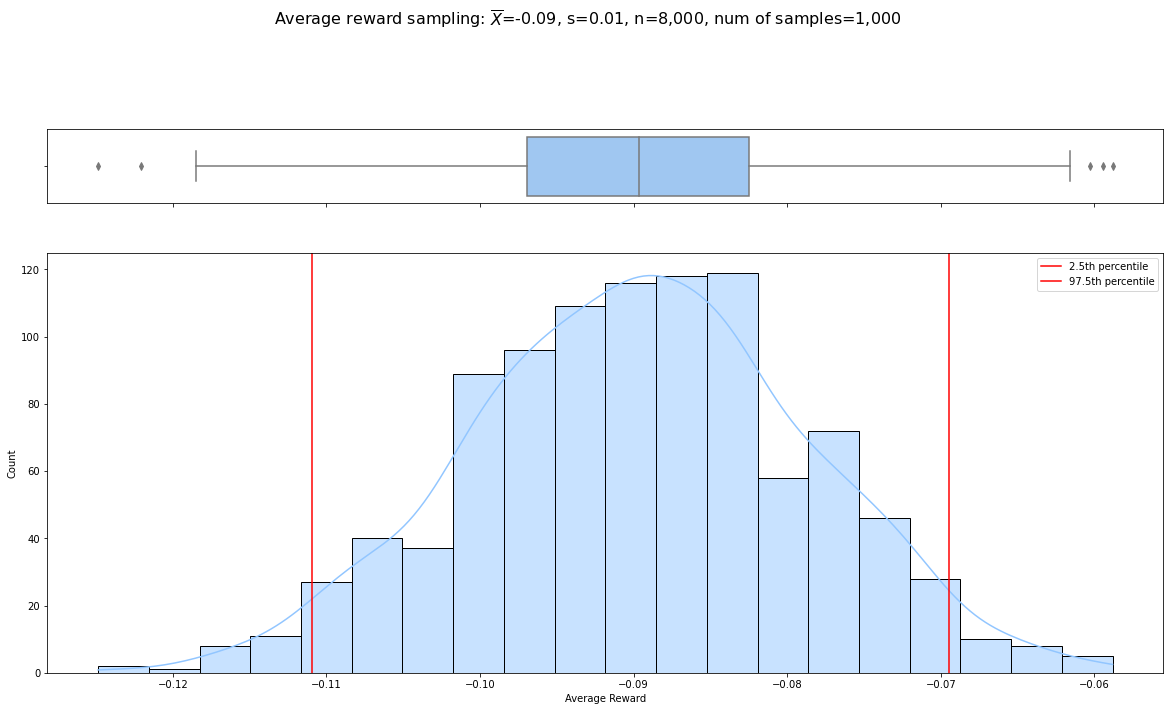

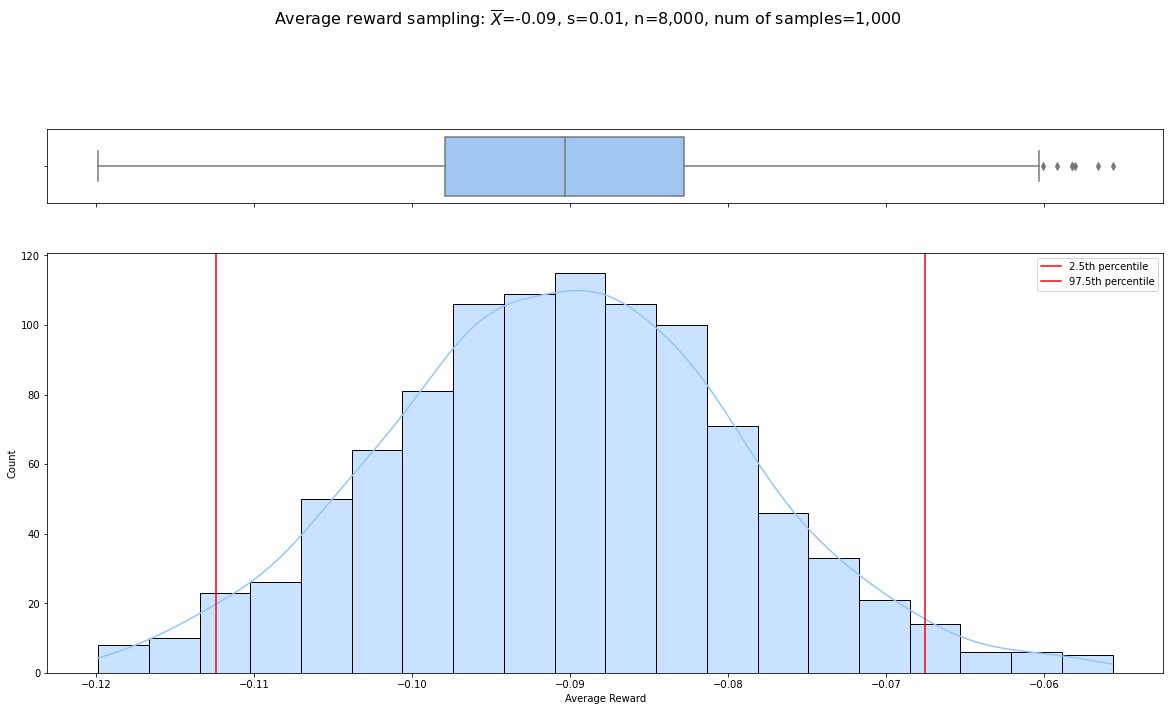

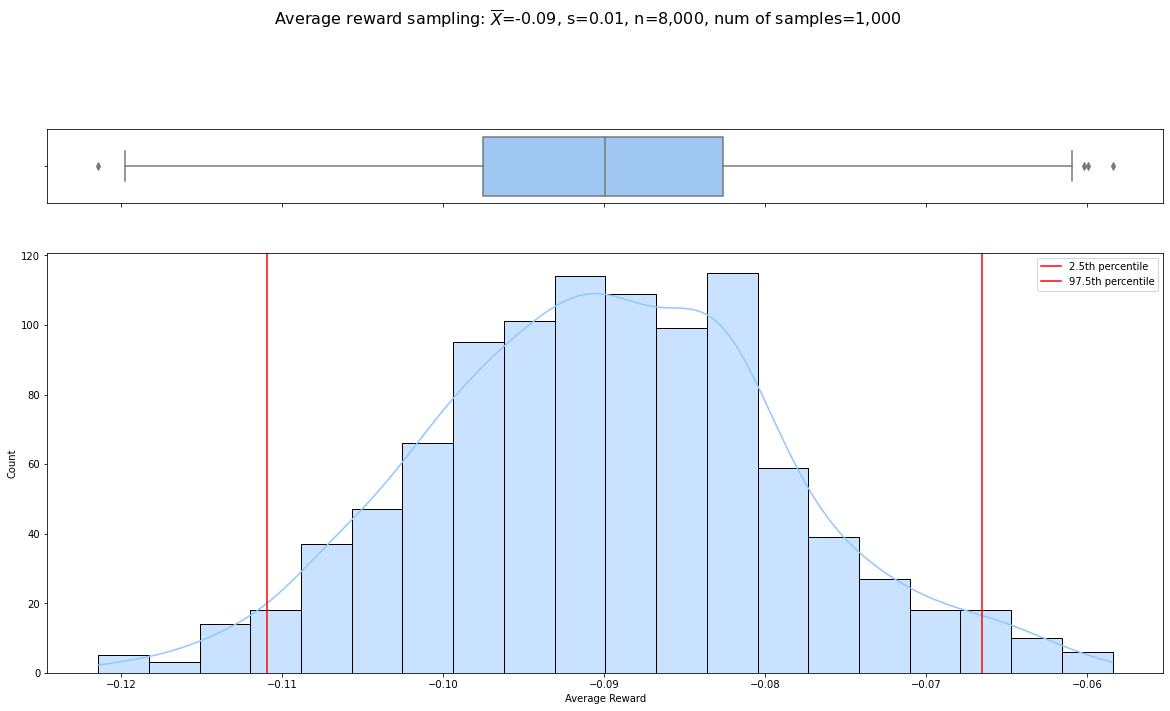

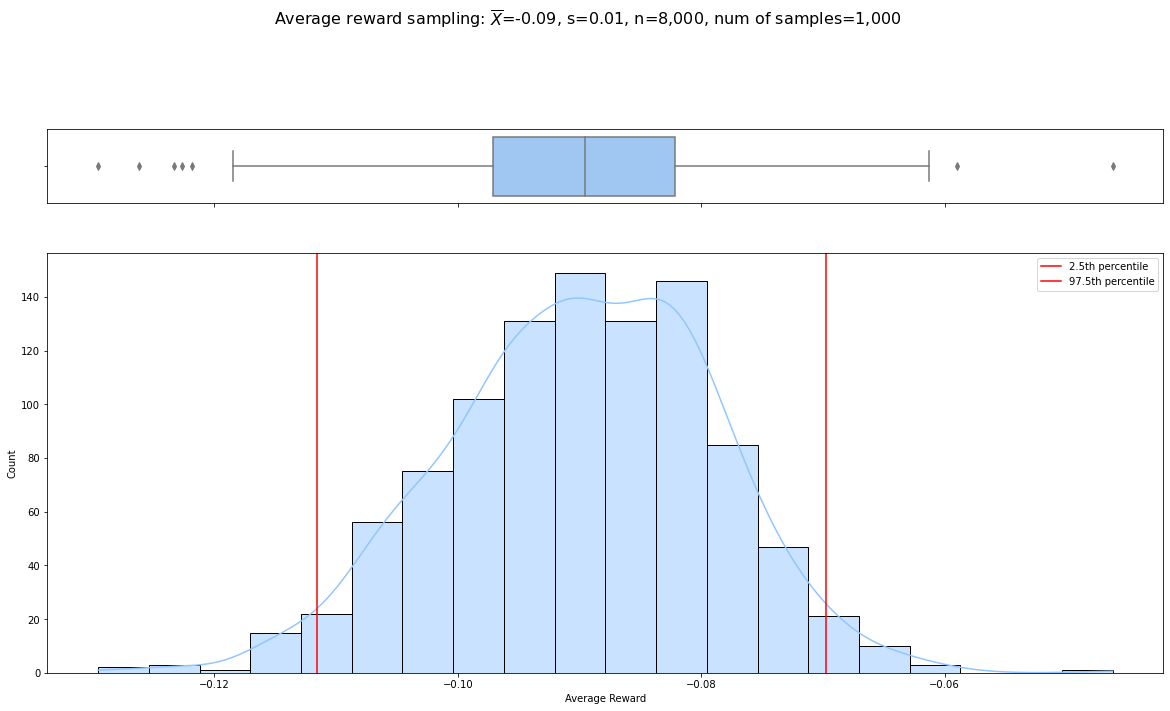

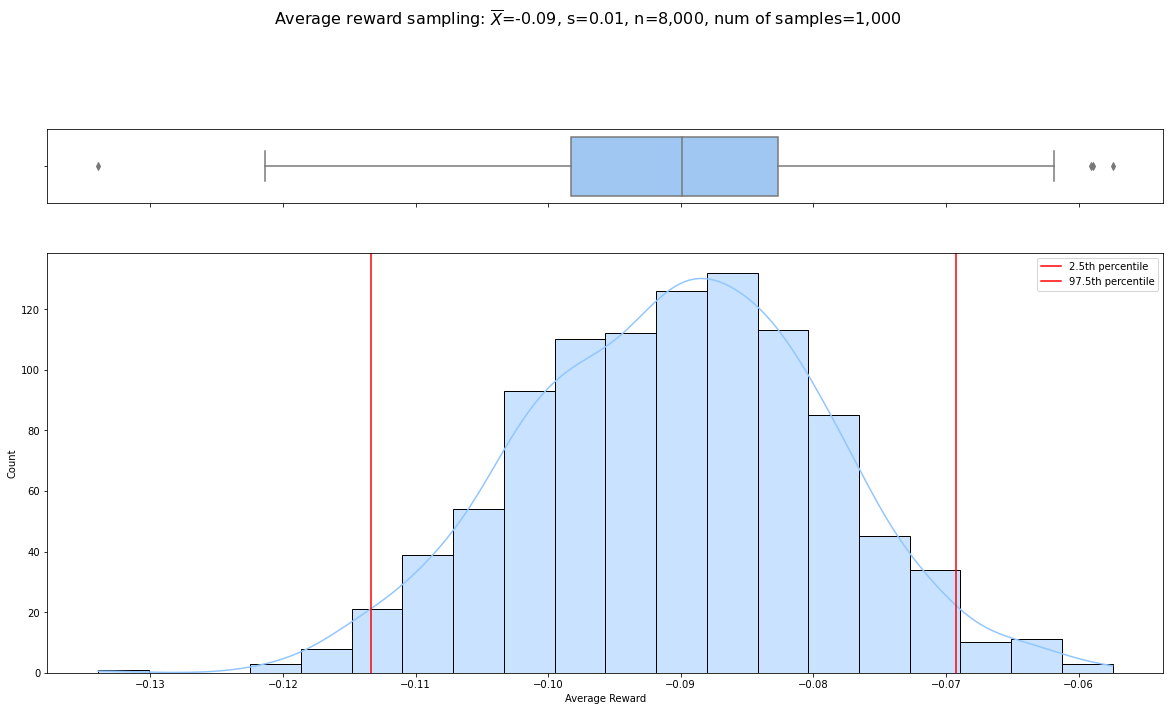

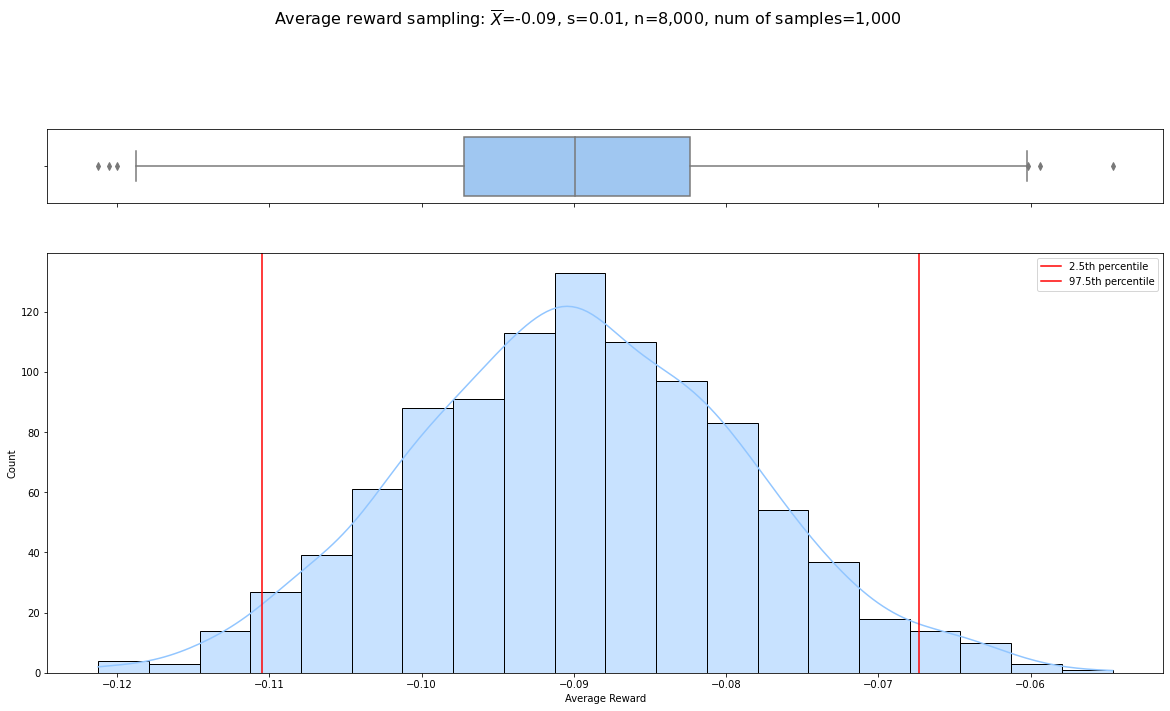

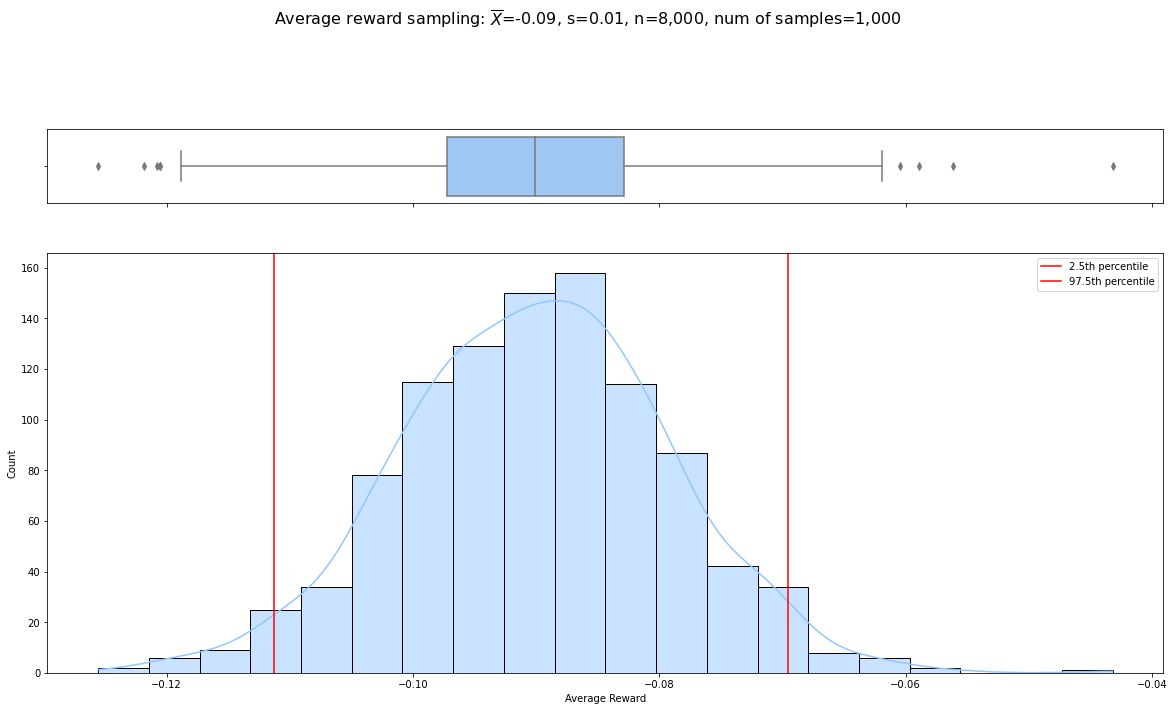

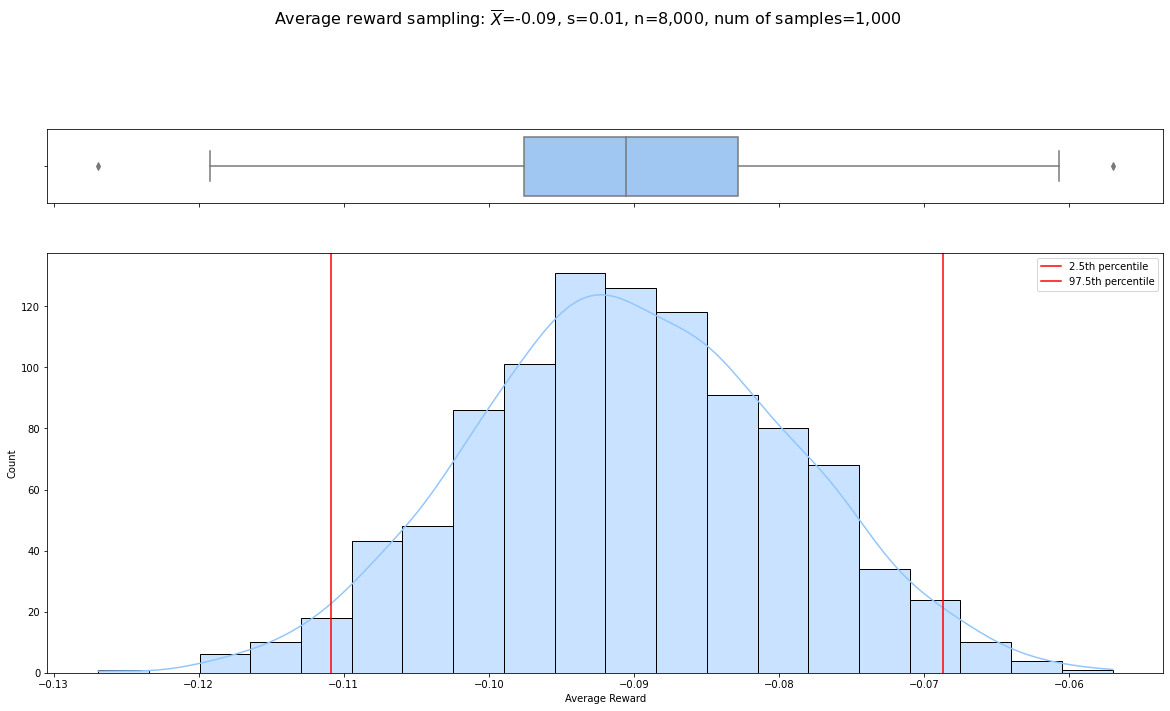

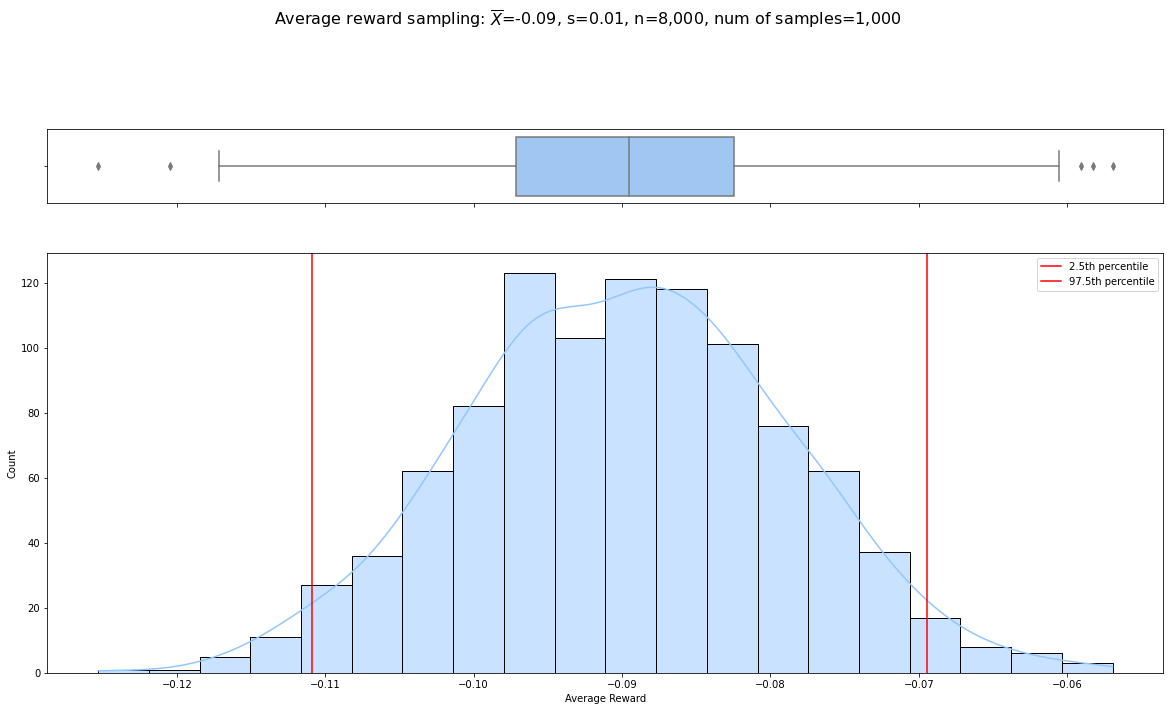

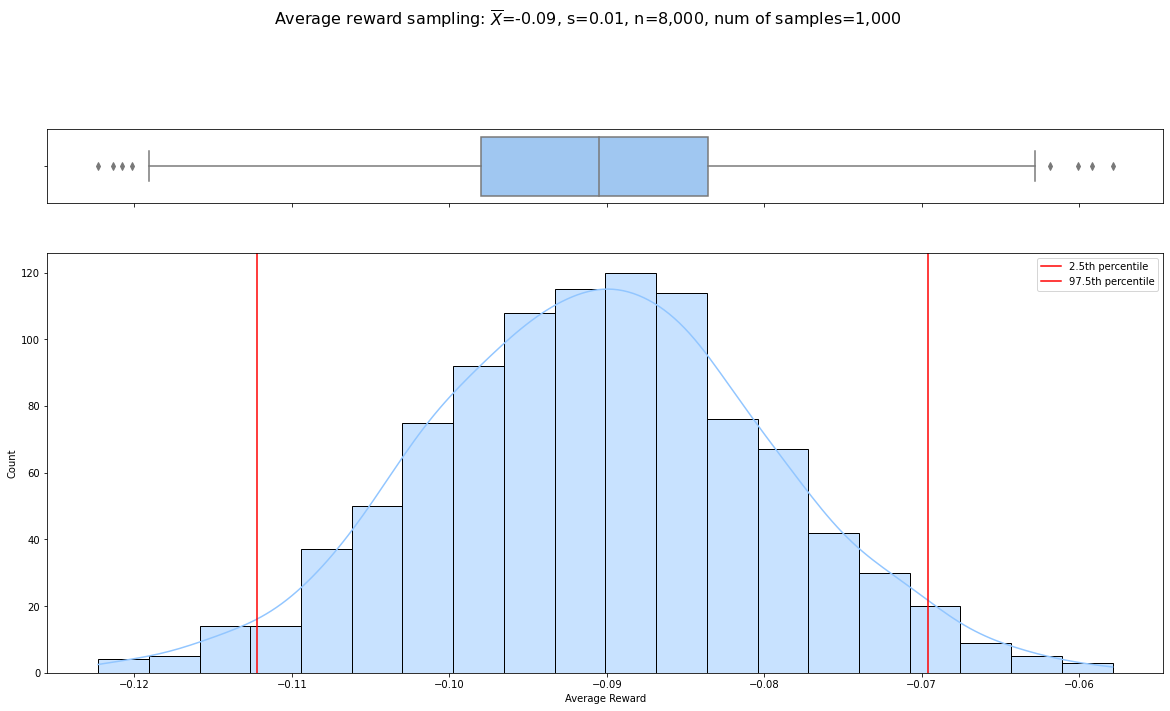

In [138]:
for key, value in bootstrap.items():
    s = pd.Series(value, index=range(SAMPLE_SIZE, SAMPLE_SIZE*1_000 + 1, SAMPLE_SIZE))
    plot_density(s);

Mean and 2.5th and 97.5th percentiles look consistent throughout all executed runs.

----

## Combining training and evaluation (test)

On one hand, I wrote the first two notebooks to showcase some hand-made RL algorithms(class development and instanciation), train them (experiment definitions) and show how to evaluate their performances (metric collection and plotting).

However, results looked very volatile and did not always seem to move upwards. On the other hand, I have written the above sections of this notebook to address those problems and report accurate results (sample size election and some sort of bootstrapping to provide confidence intervals).

It is time to let all I have done thus far coalesce into one single process: one that allows a fitful evaluation of an agent's progress over a training experiment.

In [20]:
#subclass for prediction:
class Evaluator(MonteCarloPredictor):
    #greedy policy:
    def follow_policy(self, observation, *args):
        table_look_up = tuple(self.table_look_up(observation))
        action = np.argmax(self.table[table_look_up][:])
        
        return action

In [29]:
#subclass for control
class Learner(MontecarloController):
    #greedy policy with exploration:
    def follow_policy(self, observation, *args):
        table_look_up = tuple(self.table_look_up(observation))
        max_action = np.argmax(self.table[table_look_up][:])
        probs = np.ones(self.environment.action_space_len) * self.hyperparams['epsilon_min']/self.environment.action_space_len
        probs[max_action] = 1 - self.hyperparams['epsilon_min']/self.environment.action_space_len
        
        return np.random.choice(self.environment.action_space_len, p=probs)
    

In [93]:
#Control agent instance:
learner = Learner(env)

In [31]:
# I tweak the parallelized process by passing the evaluator agent as an argument (second argument):
def put_q_test(q, agent, episodes, show_every, save_every, collect_every):
    """
    q: Queue from multiprocessing library
    """
    q.put(agents_methods[agent.get_parent_class_str()](env, agent, episodes, show_every, save_every, collect_every, train=False))
    

In [32]:
def train_and_test(env, agent, test_until, test_every, sample_size=8_000, bootstrap_samples=1_000):
    """
    env: 
    agent: control agent instance
    test_until: total number of episodes.
    test_every: indicates how often evaluation is carried out. The agent's table is also saved then.
    sample_size: how many episodes are averaged.
    bootstrap_samples: how many samples of sample_size size are produced to determine the metric's CI.
    
    returns: a dictionary containing results, mean and percentiles for each evaluation
    """
    def test(a):
        """
        Parallelized execution
        a: Prediction agent instance
        
        returns: a dictionary containing the whole list of results,
                 the mean, the 2.5th percentile, and the 97.5 percentile.
        """
        rewards = {'results':[]}
        queue = mp.Manager().Queue()
        cores = mp.cpu_count()
    
        #I split the whole test amongst the computer's cores:
        EPISODES =  sample_size * bootstrap_samples // cores
        SHOW_EVERY = 1_000_000
        SAVE_EVERY =  None
        COLLECT_EVERY = sample_size
        
        # I enqueue every run
        for _ in range(0, cores):
            mp.Process(target=put_q_test, args=(queue, a, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY,)).start()

        getter = []  
        #I create a pool of workers to handle dequeuing and subsequent execution:
        pool = mp.Pool(cores)
        for _ in range(0, cores):
            getter.append(pool.apply_async(get_q, (queue,)))

        #I extract results from every process and attach them to the dictionary:
        for r in getter:
            rewards['results'].extend(r.get())
        
        #statistics:
        rewards['mean'] = np.array(rewards['results']).mean()
        rewards['lower_bound'] = float(np.percentile(np.array(rewards['results']), [2.5]))
        rewards['upper_bound'] = float(np.percentile(np.array(rewards['results']), [97.5]))
        
        return rewards
            
    summary = {}
    for episodes in range(test_every, test_until + 1, test_every):
        _ = agents_methods[agent.get_parent_class_str()](env, agent, test_every, 1_000_000, None, 1, True)
        #table persistance:
        agent.save_table()
        #Instanciating a brand new prediction agent for each evaluation:
        evaluator = Evaluator(env)
        #Copy the Q-table to be tested:
        evaluator.table = agent.table.copy()
        summary[episodes] = test(evaluator)
        
    return summary

In [33]:
rewards = train_and_test(env, learner, 1_000_000, 50_000,bootstrap_samples=1_000)

Episode 1000000:
Jack:
	-Cards: ['2D', '6S']
	-Value : 8
Dealer:
	-Cards: ['9D']
	-Value : 9
Jack decides to: HIT
	-Cards: ['2D', '6S', '2D']
	-Value : 10
Jack decides to: HIT
	-Cards: ['2D', '6S', '2D', '5S']
	-Value : 15
Jack decides to: STAND
	-Cards: ['2D', '6S', '2D', '5S']
	-Value : 15
Dealer:
	-Cards: ['9D', 'QC']
	-Value : 19
THE HOUSE BEATS JACK
Episode 1000000:
Jack:
	-Cards: ['5S', 'QH']
	-Value : 15
Dealer:
	-Cards: ['8H']Episode 1000000:
	-Value : 8
Jack decides to: HIT
Jack:

	-Cards: ['5S', 'QH', '10H']	-Cards: ['JD', '6D']
	-Value : 16
Dealer:
	-Cards: ['3S']
	-Value : 3
Jack decides to: STAND

	-Cards: ['JD', '6D']
	-Value : 16
Dealer:
	-Cards: ['3S', 'JH', '9C']	-Value : 25

	-Value : 22Dealer:
	-Cards: ['8H']

JACK BEATS THE HOUSE	-Value : 8

THE HOUSE BEATS JACK
Episode 1000000:
Jack:
	-Cards: ['JD', '4S']
	-Value : 14
Dealer:
	-Cards: ['4C']
	-Value : 4
Jack decides to: STAND
	-Cards: ['JD', '4S']
	-Value : 14
Dealer:
	-Cards: ['4C', '8C', 'JD']
	-Value : 22
JACK B

Let's have a quick look at how average rewards have evolved over the experiment:

In [103]:
for k, v in rewards.items():
    print('After {:,.0f} episodes:\n'.format(k),
          '\tMean: {0:,.4f}\n'.format(v['mean']),
          '\t2.5th percentile: {0:,.4f}\n'.format(float(v['lower_bound'])),
          '\t97.5th percentile: {0:,.4f}\n'.format(float(v['upper_bound'])))

After 50,000 episodes:
 	Mean: -0.0754
 	2.5th percentile: -0.0955
 	97.5th percentile: -0.0556

After 100,000 episodes:
 	Mean: -0.0560
 	2.5th percentile: -0.0773
 	97.5th percentile: -0.0336

After 150,000 episodes:
 	Mean: -0.0488
 	2.5th percentile: -0.0709
 	97.5th percentile: -0.0272

After 200,000 episodes:
 	Mean: -0.0438
 	2.5th percentile: -0.0646
 	97.5th percentile: -0.0210

After 250,000 episodes:
 	Mean: -0.0414
 	2.5th percentile: -0.0626
 	97.5th percentile: -0.0197

After 300,000 episodes:
 	Mean: -0.0373
 	2.5th percentile: -0.0586
 	97.5th percentile: -0.0173

After 350,000 episodes:
 	Mean: -0.0387
 	2.5th percentile: -0.0586
 	97.5th percentile: -0.0179

After 400,000 episodes:
 	Mean: -0.0375
 	2.5th percentile: -0.0596
 	97.5th percentile: -0.0153

After 450,000 episodes:
 	Mean: -0.0356
 	2.5th percentile: -0.0561
 	97.5th percentile: -0.0139

After 500,000 episodes:
 	Mean: -0.0337
 	2.5th percentile: -0.0565
 	97.5th percentile: -0.0112

After 550,000 episode

In a fancier way:

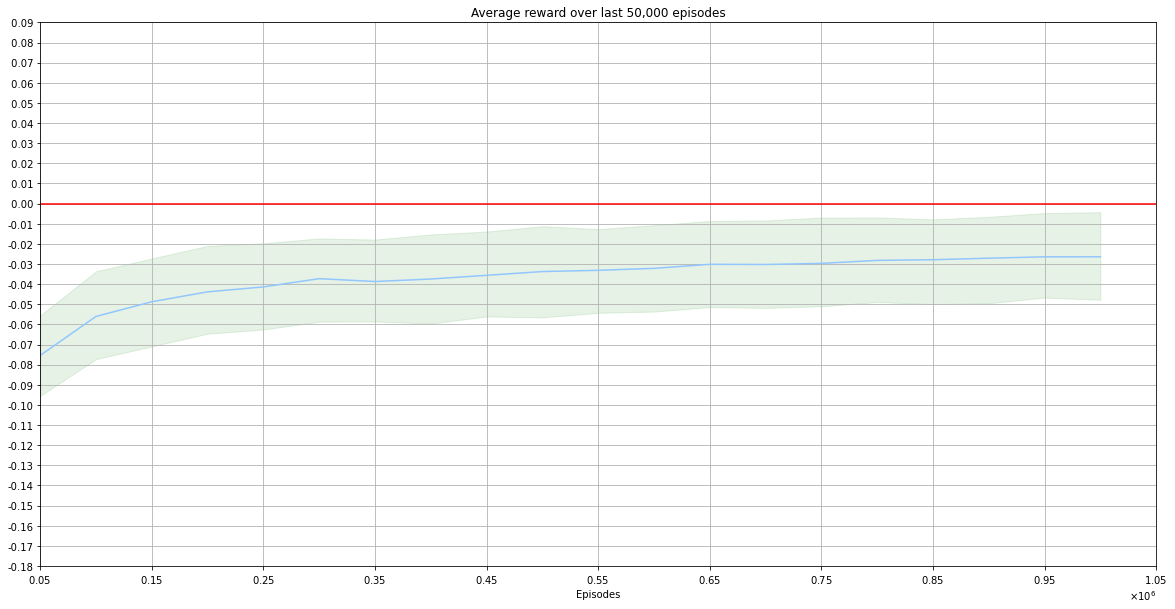

In [109]:
plot_reward_time_series(list(rewards.keys()), [v['mean'] for v in rewards.values()],
                        far=False, lower=[float(v['lower_bound']) for v in rewards.values()],
                        upper=[float(v['upper_bound']) for v in rewards.values()]);

I plot what strategy the agent is following when the experiment ends:

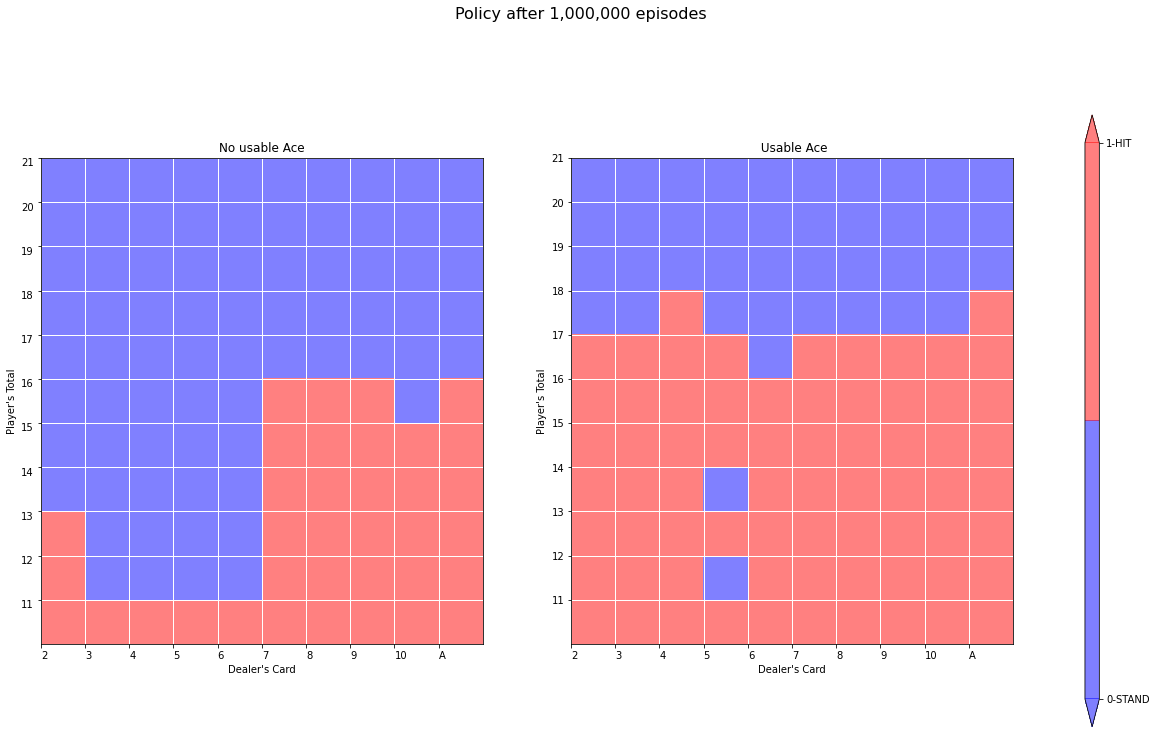

In [39]:
policy_table = np.argmax(learner.table, axis=3)
plot_policy(policy_table, 'Policy after {:,.0f} episodes'.format(1_000_000));

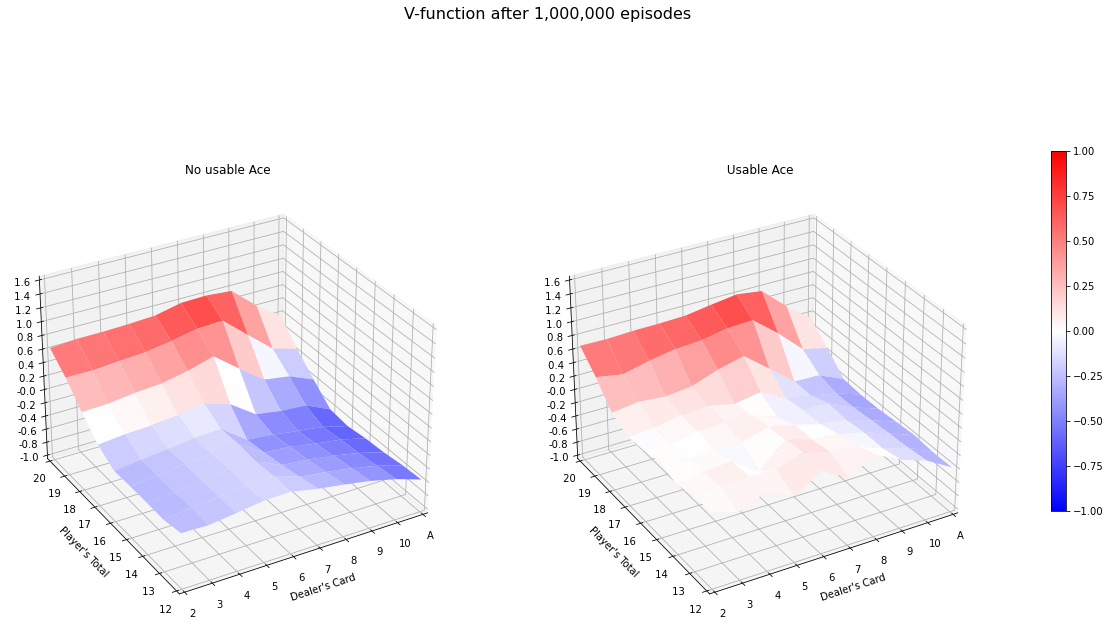

In [89]:
plot_v_func(np.amax(learner.table, axis=3), 'V-function after {:,.0f} episodes'.format(1_000_000));

The agent has worked hard, so it is worth saving it for future experimentation

In [91]:
learner.save(1_000_000)

In [92]:
learner.id

'0b3ad53fd8174602b46e261372c0c583'